# Example Analysis - Pro-/Anti-Reach Task

This Python code showcases some of the data stored in the JSON experiment data format, as well as common analyses like extracting trial results, movement sample data, and participant metadata. 

In [1]:
%matplotlib notebook

import os
import glob
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Set1_9

plt.style.use('seaborn-whitegrid')

In [2]:
folder_data = '../data'

CONDS = ['left_pro', 'right_pro', 'left_anti', 'right_anti']
CONDS_TEXT = ['Left / Pro', 'Right / Pro', 'Left / Anti', 'Right / Anti']

# Participants to show in example figures
EXAMPLE_PPID = 2
GAZE_EXAMPLE_PPID = 1

## Data Import and Preprocessing

This section extracts individual datasets from the JSON files and combines them for analysis. Afterwards, we end up with the following data structures:
    
- *data*: dict of all raw JSON datasets, not analyzed further here
- *trials*: pandas DataFrame of behavioral results, one row per trial
- *samples*: list of DataFrames with movement and gaze data, one per trial, matched to *trials*
- *metadata*: DataFrame of demographic metadata, one row per participant
- *gaze_acc*: DataFrame of average eye tracking quality, one row per participant
- *gaze_targets*: dict of DataFrames for each calibration target (5 targets), structure like *gaze_acc*

In [3]:
# Import all experiment data from the JSON file
data = {}
metadata = []
gaze_acc = []
gaze_targets = {}
trials = []
samples = []

data_files = glob.glob(os.path.join(folder_data, '*.json'))
for df in data_files:
    
    with open(df, 'r') as dfh:
        expdata = json.load(dfh)
        
        # Contents of the expdata dict imported from JSON are:
        # dict_keys(['eye_tracker_validations', 'participant', 'config', 'name', 'trials'])

        # Copy the demographic data entered at experiment start
        metadata.append(expdata['participant'].copy())
        ppid = int(expdata['participant']['id'])
        
        # Extract the averaged gaze validation data
        metrics = expdata['eye_tracker_validations'][0].copy()
        gaze_targets[ppid] = pd.DataFrame(metrics['targets'])        
        del metrics['targets']
        del metrics['samples']
        del metrics['metadata']
        metrics['ppid'] = ppid
        gaze_acc.append(metrics)
        
        # Target / eye height and distance were saved to the config structure,
        # as they were the same for all trials
        eyeheight = expdata['config']['eyeheight']
        tar_dist = expdata['config']['tar_dist']

        # Trial data
        # This can also be saved and imported as a CSV text file 
        for trial in expdata['trials']:
            
            # Combine trial parametrs and results into one dict
            tdata = trial['params'].copy()
            tdata.update(trial['results'])
            
            # Add target information to the trial table for easier analysis
            tdata['ppid'] = ppid
            tdata['trial_index'] = trial['index']
            tdata['tar_y'] = eyeheight
            tdata['tar_z'] = tar_dist

            # Define a condition label for analysis
            if tdata['pro'] == 1 and tdata['target'] == 'left':
                tdata['condition'] = 'left_pro'
                tdata['tar_x_eff'] = -0.3
            elif tdata['pro'] == 0 and tdata['target'] == 'left':
                tdata['condition'] = 'left_anti'
                tdata['tar_x_eff'] = 0.3
            elif tdata['pro'] == 1 and tdata['target'] == 'right':
                tdata['condition'] = 'right_pro'
                tdata['tar_x_eff'] = 0.3
            elif tdata['pro'] == 0 and tdata['target'] == 'right':
                tdata['condition'] = 'right_anti'
                tdata['tar_x_eff'] = -0.3

            trials.append(tdata)
            
            # Extract movement sample data
            sam = pd.DataFrame(trial['samples'])
            samples.append(sam)

        # Main data dict
        data[ppid] = expdata

metadata = pd.DataFrame(metadata)
metadata.loc[:, 'age'] = pd.to_numeric(metadata.loc[:, 'age']) # Metadata are strings by default

gaze_acc = pd.DataFrame(gaze_acc)
trials = pd.DataFrame(trials)

# Calculate horizontal endpoint error to cued target location
trials.loc[:, 'endpoint_error'] = np.abs(trials.hit_x - trials.tar_x_eff)

display(trials.head())

,pro,target,feedback,RT,hit_z,hit_y,hit_x,reach_time,go_time,start_time,hemifield,fix_onset_time,correct,ppid,trial_index,tar_y,tar_z,condition,tar_x_eff,endpoint_error
0,0,right,1,555.6621,0.452215,1.308847,-0.259424,76502.9517,75947.2896,77612.8429,left,73925.7888,True,1,0,1.263211,0.5,right_anti,-0.3,0.040576
1,1,right,0,489.5285,0.454351,1.294622,0.270558,80134.6271,79645.0986,81217.7487,right,77624.4602,True,1,1,1.263211,0.5,right_pro,0.3,0.029442
2,0,left,0,499.8213,0.456599,1.303491,0.292787,83744.2781,83244.4568,84738.3681,right,81229.1536,True,1,2,1.263211,0.5,left_anti,0.3,0.007213
3,0,left,1,400.6027,0.456904,1.280949,0.253285,87164.9824,86764.3797,88270.1416,right,84749.7434,True,1,3,1.263211,0.5,left_anti,0.3,0.046715
4,1,right,1,267.0741,0.454922,1.274216,0.267579,90752.2566,90485.1825,91768.5851,right,88470.3975,True,1,4,1.263211,0.5,right_pro,0.3,0.032421


The above table shows the structure of per-trial behaviroal data for the first five trials in the dataset. 

The next two cells extract the hand movement trajectories for each trial, align them with the trial start (time when the participant fixated on the target sphere), then group and average trajectories for each of the four movement conditions (pro/left, pro/right, anti/left, anti/right).

In [4]:
# Calculate movement onsets for each trial based on velocity
ONSET_VEL = 0.003

movements = []

# Separate trajectories by condition
proL = []
antiL = []
proR = []
antiR = []
max_len = 0

for trial in trials.iterrows():
    
    idx = trial[0]
    t = trial[1]
    s = samples[idx].copy()
    
    # Calculate velocity per axis by numerical differentiation
    # For this simple analysis, we are ignoring time stamp variability
    s.loc[:, 'vX'] = s.controller_posX.diff()
    s.loc[:, 'vY'] = s.controller_posY.diff()
    s.loc[:, 'vZ'] = s.controller_posZ.diff()
    s.loc[:, 'is_onset'] = 0
    s.loc[:, 'is_offset'] = 0

    # Add time column relative to go cue time
    s.loc[:, 'time_rel'] = s.time - t.go_time
    samples[idx].loc[:, 'time_rel'] = s.loc[:, 'time_rel']
    
    # Skip beginning of the trial
    # Note that fix_onset_time means the onset of the *participant's* fixation on the target
    s = s.loc[s.time >= (t.fix_onset_time), :]

    # Remove all samples with negative velocities (return movement)
    s = s.loc[s.vZ > 0, :]

    # Find first timestamp where Z (forward) velocity exceeds threshold
    onset_idx = np.argmax(s.vZ.values >= ONSET_VEL)
    onset = s.time.values[onset_idx]
    latency = onset - t.go_time
    s.loc[s.index[onset_idx], 'is_onset'] = 1

    # We use the reach time (vizproximity sensor) for movement end for this example
    # Note that this indicates the time the hand crossed the distance threshold, 
    # but actual reach endpoints might be a bit further
    offset = t.reach_time
    duration = offset - onset
    
    # Add movement timing data to trial table for timing analysis
    trials.loc[idx, 'move_onset'] = onset
    trials.loc[idx, 'move_offset'] = offset
    trials.loc[idx, 'move_latency'] = latency
    trials.loc[idx, 'move_duration'] = duration
    
    # Sort sample participant traces by condition
    if t.ppid == EXAMPLE_PPID:
        trace = samples[idx].loc[(samples[idx].time >= t.go_time) & (samples[idx].time <= offset), ('controller_posX', 'controller_posY', 'controller_posZ')].values
        if t.target == 'left' and t.pro == 1:
            proL.append(trace)
        elif t.target == 'left' and t.pro == 0:
            antiL.append(trace)
        elif t.target == 'right' and t.pro == 1:
            proR.append(trace)
        elif t.target == 'right' and t.pro == 0:
            antiR.append(trace)
        if trace.shape[0] > max_len:
            max_len = trace.shape[0]

    if s.shape[0] > 0:
        s.loc[:, 'move_time'] = s.time - s.time.values[0]
    
    movements.append(s)

print(trials.shape, len(movements))

(400, 24) 400


In [5]:
# Calculate average trajectories for pro/anti reaches

# Movements have different lengths, so we align with onset
# and average positions while dropping NaNs
pro_left = np.ones((max_len, 3, len(proL))) * np.nan
anti_left = np.ones((max_len, 3, len(antiL))) * np.nan
pro_right = np.ones((max_len, 3, len(proR))) * np.nan
anti_right = np.ones((max_len, 3, len(antiR))) * np.nan

for ix, tr in enumerate(proL):
    pro_left[0:tr.shape[0], :, ix] = tr
pro_left = np.nanmedian(pro_left, 2)

for ix, tr in enumerate(proR):
    pro_right[0:tr.shape[0], :, ix] = tr
pro_right = np.nanmedian(pro_right, 2)

for ix, tr in enumerate(antiL):
    anti_left[0:tr.shape[0], :, ix] = tr
anti_left = np.nanmedian(anti_left, 2)

for ix, tr in enumerate(antiR):
    anti_right[0:tr.shape[0], :, ix] = tr
anti_right = np.nanmedian(anti_right, 2)


/home/immo/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Now perform outlier correction on the movement parameters, i.e. remove trials with unsually short or long movement onset latency or duration (i.e., +/- 3 standard deviations).

In [6]:
# Outlier correction for movement latency and movement duration
SDS = 3.0
trials.loc[:, 'valid'] = 1

# Movement latency
lat_m = trials.loc[trials.valid == 1, :].move_latency.mean()
lat_sd = trials.loc[trials.valid == 1, :].move_latency.std()
trials.loc[(trials.move_latency <= lat_m - (SDS * lat_sd)) | (trials.move_latency >= lat_m +( SDS * lat_sd)), 'valid'] = 0

# Movement duration
dur_m = trials.loc[trials.valid == 1, :].move_duration.mean()
dur_sd = trials.loc[trials.valid == 1, :].move_duration.std()
trials.loc[(trials.move_duration <= dur_m - (SDS * dur_sd)) | (trials.move_duration >= dur_m + (SDS * dur_sd)), 'valid'] = 0

invalid = trials.shape[0] - trials.valid.sum()
valid_percent = (trials.valid.sum() / trials.shape[0]) * 100
print('{:d} trials removed, {:.2f}% valid trials'.format(invalid, valid_percent))
display(trials.groupby('ppid').sum().valid.to_frame().T)

trials_valid = trials.loc[trials.valid == 1, :].copy()
print(trials_valid.shape)


10 trials removed, 97.50% valid trials


ppid,1,2,3,4,5
valid,80,79,80,72,79


(390, 25)


## Demographics and Eye Tracking Accuracy

Here we show typical demographic informations that might go into a *Participants* section in a paper. We also calculate group average, minimum and maximum eye tracking accuracy in degrees and plot individual accuracy data for each tested calibration target below. 

In [7]:
# Extract demographic information on participants
display(metadata.loc[:, 'age'].describe().to_frame().T)
display(metadata.loc[:, 'gender'].value_counts().to_frame())

,count,mean,std,min,25%,50%,75%,max
age,5.0,31.2,6.534524,22.0,29.0,30.0,37.0,38.0


,gender
male,3
female,2


In [8]:
# Descriptives on eye tracking validation data
display(gaze_acc.loc[:, 'acc'].describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
acc,5.0,0.508729,0.110807,0.396905,0.405096,0.498449,0.60969,0.633508


<IPython.core.display.Javascript object>


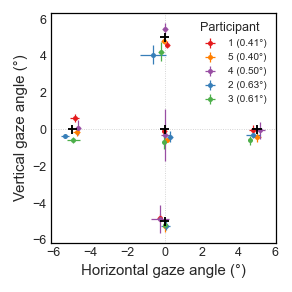

In [9]:
# Gaze accuracy plot
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.25), dpi=90)

labels = []
handles = []

# Plot calibration target positions in degrees
ax.axhline(0, linestyle=':', linewidth=0.7, color=[0.8, 0.8, 0.8], zorder=1)
ax.axvline(0, linestyle=':', linewidth=0.7, color=[0.8, 0.8, 0.8], zorder=1)
ax.errorbar(x=gaze_targets[1].x, y=gaze_targets[1].y, xerr=0.25, yerr=0.25, marker=None, 
                    markersize=4, linewidth=0, elinewidth=1.5, color='k', zorder=10)

# Plot individual results per target
for ppid in gaze_targets.keys():
    tar_df = gaze_targets[ppid]
    
    h = ax.errorbar(x=tar_df.avgX, y=tar_df.avgY, xerr=tar_df.sdX, yerr=tar_df.sdY, marker='o', solid_joinstyle='round',
                       markersize=4, linewidth=0, elinewidth=1.0, color=Set1_9.mpl_colors[ppid-1], markeredgecolor="None")
    handles.append(h)
    
    # Add average accuracy to legend
    acc = gaze_acc.loc[gaze_acc.ppid == ppid, 'acc'].values[0]
    labels.append('{:d} ({:.2f}°)'.format(ppid, acc))

ax.set_xlabel('Horizontal gaze angle (°)', fontsize=12)
ax.set_ylabel('Vertical gaze angle (°)', fontsize=12)
ax.set_xticks([-6, -4, -2, 0, 2, 4, 6])
ax.set_yticks([-6, -4, -2, 0, 2, 4, 6])
ax.tick_params(axis='both', which='major', labelsize=10)
legend = ax.legend(handles, labels, title='Participant', frameon=False, fontsize=8, loc='upper right')
legend._legend_box.align='left'

ax.grid(False, which='major', axis='x')
ax.grid(False, which='major', axis='y')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.0)
    ax.spines[axis].set_color('k')

# Save figure
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('fig_gaze_acc.png', bbox_inches='tight', dpi=150)

## Per-Trial Behavioral Data

These cells give an example of behavioral data recorded as one data point per trial, such as the timing of each movement, distance between hand and target when the distance threshold was crossed, and whether the response (movement direction) was correct with regard to the color cue or not.

In [10]:
# Percent correct responses (left / right hemifield)
per_corr = trials_valid.groupby('condition').agg({'correct': 'sum', 'ppid': 'count'})
per_corr.loc[:, 'percent_correct'] = (per_corr.correct / per_corr.ppid) * 100
display(per_corr)

,correct,ppid,percent_correct
condition,,,
left_anti,99,99,100.000000
left_pro,94,95,98.947368
right_anti,96,96,100.000000
right_pro,100,100,100.000000


<IPython.core.display.Javascript object>


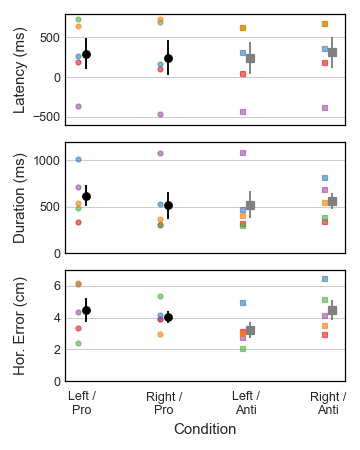

In [11]:
# Plot movement timing parameters
DODGE = 0.05

fig = plt.figure(figsize=(4, 5), dpi=90)
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

for cidx, cond in enumerate(CONDS):

    if cond.split('_')[1] == 'pro':
        marker = 'o'
        mcolor = 'k'
    else:
        marker='s'
        mcolor = 'gray'

    # Individual participant data
    indiv = trials_valid.loc[(trials_valid.condition == cond), :].groupby('ppid').mean().reset_index()

    # Onset Latency
    for ppid in indiv.ppid.values:
        ax1.plot(cidx - DODGE, indiv.loc[indiv.ppid == ppid, 'move_latency'], 
                 color=Set1_9.mpl_colors[ppid-1], marker=marker, markersize=4, alpha=0.6)
    
    # Duration
    for ppid in indiv.ppid.values:
        ax2.plot(cidx - DODGE, indiv.loc[indiv.ppid == ppid, 'move_duration'], 
                 color=Set1_9.mpl_colors[ppid-1], marker=marker, markersize=4, alpha=0.6)
    
    # Endpoint error
    for ppid in indiv.ppid.values:
        ax3.plot(cidx - DODGE, indiv.loc[indiv.ppid == ppid, 'endpoint_error'] * 100,
                 color=Set1_9.mpl_colors[ppid-1], marker=marker, markersize=4, alpha=0.6)
    
    # Averages + SE
    lat_avg = indiv.move_latency.mean()
    lat_avg_se = indiv.move_latency.std() / np.sqrt(indiv.shape[0])
    dur_avg = indiv.move_duration.mean()
    dur_avg_se = indiv.move_duration.std() / np.sqrt(indiv.shape[0])
    err_avg = indiv.endpoint_error.mean()
    err_avg_se = indiv.endpoint_error.std() / np.sqrt(indiv.shape[0])
    
    ax1.errorbar(x=cidx + DODGE, y=lat_avg, yerr=lat_avg_se, color=mcolor, marker=marker, markersize=6, alpha=1.0)
    ax2.errorbar(x=cidx + DODGE, y=dur_avg, yerr=dur_avg_se, color=mcolor, marker=marker, markersize=6, alpha=1.0)
    ax3.errorbar(x=cidx + DODGE, y=err_avg * 100, yerr=err_avg_se * 100, color=mcolor, marker=marker, markersize=6, alpha=1.0)

ax1.set_ylabel('Latency (ms)', fontsize=12)
ax1.set_xticklabels([])
ax1.set_ylim([-600, 800])

ax2.set_ylabel('Duration (ms)', fontsize=12)
ax2.set_ylim([0, 1200])
ax2.set_xticklabels([])

ax3.set_ylabel('Hor. Error (cm)', fontsize=12)
ax3.set_xlabel('Condition', fontsize=12)
ax3.set_xticks(range(0, len(CONDS)))
ax3.set_xticklabels(['Left /\nPro', 'Right /\nPro', 'Left /\nAnti', 'Right /\nAnti'])
ax3.xaxis.set_tick_params(pad=8)
ax3.set_ylim([0, 7])

for ax in [ax1, ax2, ax3]:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.0)
        ax.spines[axis].set_color('k')
    ax.grid(False, which='major', axis='x')

# Save figure
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(hspace=0.15)
plt.savefig('fig_behavioral.png', bbox_inches='tight', dpi=150)


## Continuous Behavioral Data

Finally, we plot some example of continuous behavioral data, recorded at 90 Hz (once per VR HMD display frame). 

<IPython.core.display.Javascript object>


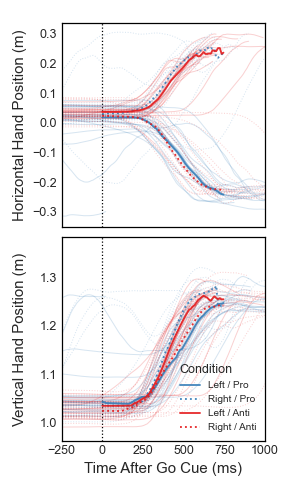

In [12]:
# Controller movement data
TRACE_WIDTH = 0.8
TRACE_ALPHA = 0.2
AVG_WIDTH = 1.5
AVG_ALPHA = 0.9
MAX_AVG_SAMPLES = 68 # average for ~750 ms

fig, ax = plt.subplots(2, 1, figsize=(3.25, 5.45), dpi=90)

# Grab data from sample participant
tr_index = trials_valid.loc[trials_valid.ppid == EXAMPLE_PPID, :].index.values

for ix, s in enumerate(samples):
    if ix in tr_index:
        t = trials_valid.loc[ix, :]
        
        # Set plot style and collect traces
        if t.target == 'left':
            ls = '-'
        elif t.target == 'right':
            ls = ':'
        if t.pro == 1:
            color = Set1_9.mpl_colors[1]
        elif t.pro == 0:
            color = Set1_9.mpl_colors[0]

        # Plot individual trial trajectories
        ax[0].plot(s.time_rel, s.controller_posX, linestyle=ls, color=color, linewidth=TRACE_WIDTH, alpha=TRACE_ALPHA)
        ax[1].plot(s.time_rel, s.controller_posY, linestyle=ls, color=color, linewidth=TRACE_WIDTH, alpha=TRACE_ALPHA)

# Plot average trajectories
for coord in [0, 1]:
    h1, = ax[coord].plot((np.arange(0, MAX_AVG_SAMPLES) * 11.1111), pro_left[:MAX_AVG_SAMPLES, coord], linestyle='-', color=Set1_9.mpl_colors[1], linewidth=AVG_WIDTH, alpha=AVG_ALPHA)
    h2, = ax[coord].plot((np.arange(0, MAX_AVG_SAMPLES) * 11.1111), pro_right[:MAX_AVG_SAMPLES, coord], linestyle=':', color=Set1_9.mpl_colors[1], linewidth=AVG_WIDTH, alpha=AVG_ALPHA)
    h3, = ax[coord].plot((np.arange(0, MAX_AVG_SAMPLES) * 11.1111), anti_left[:MAX_AVG_SAMPLES, coord], linestyle='-', color=Set1_9.mpl_colors[0], linewidth=AVG_WIDTH, alpha=AVG_ALPHA)
    h4, = ax[coord].plot((np.arange(0, MAX_AVG_SAMPLES) * 11.1111), anti_right[:MAX_AVG_SAMPLES, coord], linestyle=':', color=Set1_9.mpl_colors[0], linewidth=AVG_WIDTH, alpha=AVG_ALPHA)

# Legend
handles = [h1, h2, h3, h4]
labels = CONDS_TEXT
legend = ax[1].legend(handles, labels, title='Condition', frameon=False, fontsize=8, loc='lower right')
legend._legend_box.align='left'

# General settings for all subplots        
ax[0].set_ylabel('Horizontal Hand Position (m)', fontsize=12)
ax[1].set_ylabel('Vertical Hand Position (m)', fontsize=12)
ax[0].set_xticks([])
ax[1].set_xlabel('Time After Go Cue (ms)', fontsize=12)

# General options for all subplots
for axx in ax:
    axx.set_xlim([-250, 1000])
    axx.axvline(0, linestyle=':', linewidth=1.0, color='k', zorder=1)
    axx.grid(False, which='major', axis='x')
    axx.grid(False, which='major', axis='y')
    for axis in ['top','bottom','left','right']:
        axx.spines[axis].set_linewidth(1.0)
        axx.spines[axis].set_color('k')

# Save figure
fig.align_labels()
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('fig_controller.png', bbox_inches='tight', dpi=150)


<IPython.core.display.Javascript object>


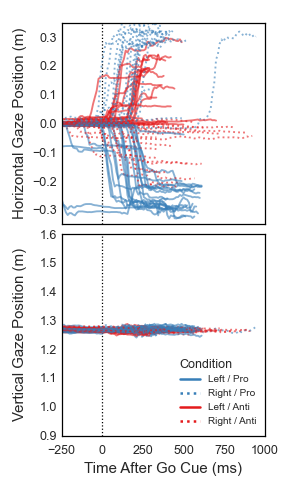

In [14]:
# Example gaze data
TRACE_WIDTH = 1.5
TRACE_ALPHA = 0.6

fig, ax = plt.subplots(2, 1, figsize=(3.25, 5.45), dpi=90)

# Grab data from sample participant
tr_index = trials_valid.loc[trials_valid.ppid == GAZE_EXAMPLE_PPID, :].index.values

# Sample Data (Subplot 1 & 2)
for ix, s in enumerate(samples):
    if ix in tr_index:

        t = trials_valid.loc[ix, :]
        onset_idx = s.time_rel.abs().argmin()
        trace_min = s.time_rel[onset_idx] - 250
        trace_max = s.time_rel[onset_idx] + 1000        
        trace = s.loc[(s.time_rel >= trace_min) & (s.time_rel <= trace_max), :]

        # Set plot style by condition
        if t.target == 'left':
            ls = '-'
            if t.pro == 1:
                color = Set1_9.mpl_colors[1]
            elif t.pro == 0:
                color = Set1_9.mpl_colors[0]

        elif t.target == 'right':
            ls = ':'
            if t.pro == 1:
                color = Set1_9.mpl_colors[1]
            elif t.pro == 0:
                color = Set1_9.mpl_colors[0]
        
        h, = ax[0].plot(s.time_rel, s.gaze3d_posX, linestyle=ls, color=color, linewidth=TRACE_WIDTH, alpha=TRACE_ALPHA)
        ax[1].plot(s.time_rel, s.gaze3d_posY, linestyle=ls, color=color, linewidth=TRACE_WIDTH, alpha=TRACE_ALPHA)


ax[0].set_ylabel('Horizontal Gaze Position (m)', fontsize=12)
ax[0].set_xlim([-250, 1000])
ax[0].set_ylim([-0.35, 0.35])
ax[0].set_xticks([])
ax[1].set_ylabel('Vertical Gaze Position (m)', fontsize=12)
ax[1].set_xlabel('Time After Go Cue (ms)', fontsize=12)
ax[1].set_xlim([-250, 1000])
ax[1].set_ylim([1.25 - 0.35, 1.25 + 0.35])
ax[1].xaxis.set_tick_params(pad=8)

# Manually create the legend from condition styles, as we have no average traces here
lpro = plt.Line2D([0,1],[0,1], linewidth=2, linestyle='-', color=Set1_9.mpl_colors[1])
lanti = plt.Line2D([0,1],[0,1], linewidth=2, linestyle='-', color=Set1_9.mpl_colors[0])
rpro = plt.Line2D([0,1],[0,1], linewidth=2, linestyle=':', color=Set1_9.mpl_colors[1])
ranti = plt.Line2D([0,1],[0,1], linewidth=2, linestyle=':', color=Set1_9.mpl_colors[0])
legend2 = ax[1].legend([lpro, rpro, lanti, ranti], CONDS_TEXT, title='Condition', frameon=False, fontsize=8, loc='lower right')
legend2._legend_box.align='left'

# General settings for all subplots
for axx in ax:
    axx.axvline(0, linestyle=':', linewidth=1.0, color='k', zorder=1)
    axx.grid(False, which='major', axis='x')
    axx.grid(False, which='major', axis='y')
    for axis in ['top','bottom','left','right']:
        axx.spines[axis].set_linewidth(1.0)
        axx.spines[axis].set_color('k')

# Save figure
fig.align_labels()
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('fig_gaze.png', bbox_inches='tight', dpi=150)